# Literature

```
POSNER, MICHAEL I.; GOLDSMITH, RALPH; WELTON, KENNETH E., Jr. (1967). PERCEIVED DISTANCE AND THE CLASSIFICATION OF DISTORTED PATTERNS.. Journal of Experimental Psychology, 73(1), 28–38. doi:10.1037/h0024135  
```

https://sci.bban.top/pdf/10.1037/h0024135.pdf#view=FitH

```
Smith, J. David; Redford, Joshua S.; Gent, Lauren C.; Washburn, David A. (2005). Visual Search and the Collapse of Categorization.. Journal of Experimental Psychology: General, 134(4), 443–460. doi:10.1037/0096-3445.134.4.443  
```
https://sci-hub.yncjkj.com/10.1037/0096-3445.134.4.443

![Posner, 1967](assets/posner-1967-fig1.png)

![Smith, 2005. Figure 1](assets/smith-2005-fig1.png)

![Smith, 2005](assets/smith-2005-appendix.png)

# Tools

mpl_point_clicker. Extension to matplotlib that lets you click on points on a graph. https://mpl-point-clicker.readthedocs.io/en/latest/

In [1]:
import imageio
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt

In [2]:
def random_points_from_grid(seed=None, num_points=9, central_area_side=30, total_area_side=50):
    '''
    "Choose 9 points randomly from the central 30x30 area of a 50x50 grid"
    Becomes the initial point of the dot distortion shapes.
    '''
    if seed is not None:
        random.seed(seed)
    points = []
    for i in range(num_points):
        x = random.randint(total_area_side/2-central_area_side/2, total_area_side/2 + central_area_side/2)
        y = random.randint(total_area_side/2-central_area_side/2, total_area_side/2 + central_area_side/2)
        points.append((x, y))
    return points

In [3]:
def create_relative_coordinates(dot_block_image_path='dot_distortion_areas.png'):
    '''
    I created a 21x21 pixel PNG image using GIMP that has different brightness values for each kind of 'area'.
    This function parses that image to return a list of tuples of relative coordinates for each area.
    Areas are 1,2,3,4,5.
    '''
    im = imageio.imread(dot_block_image_path)

    pixel_brightness = sorted(set(im[10]))
    brightness_to_areas = dict()
    for i, num in enumerate(pixel_brightness):
        brightness_to_areas.update({num: i+1})

    areas_array = np.zeros(im.shape)

    for i in range(len(areas_array)):
        for j in range(len(areas_array[i])):
            areas_array[i][j] = brightness_to_areas[im[i][j]]

    assert set(areas_array.flatten()) == {1, 2, 3, 4, 5} # ensure that all pixel values have been converted to areas indexes

    coords_per_area = []
    for k in range(1,len(set(areas_array.flatten()))+1):
        coords_per_area.append([(i,j) for i in range(len(areas_array)) for j in range(len(areas_array[i])) if areas_array[i][j] == k])

    # subtract (10,10) from all coords; turn into relative values from center pixel
    rel_coords_per_area = coords_per_area
    for i in range(len(coords_per_area)):
        rel_coords_per_area[i] = [(x-10,y-10) for (x,y) in coords_per_area[i]]

    return rel_coords_per_area
        

In [4]:
def distort_dot(coords, distortion_level, relative_shifts, area_names=[1,2,3,4,5]):
    '''
    Randomly move dot to corresponding area_name according to a probability distribution for area_names given by distortion_level

    coords (tuple(int,int)): (x, y) point coordinates
    distortion_level (str): choose from '1', '2', '3', '4', '5', '6', '7.7'
    relative_shifts (list[list[tuple(int,int)]]): list of lists of relative coordinates for each area_name
    area_names (list[int])
    '''
    level_to_probs = {
        # level names correspond to bits per dot
        # value is the probability distribution over the 5 area_names
        '1' : (0.88, 0.10, 0.015, 0.004, 0.001),
        '2' : (0.75, 0.15, 0.05, 0.03, 0.02),
        '3' : (0.59, 0.20, 0.16, 0.03, 0.02),
        '4' : (0.36, 0.48, 0.06, 0.05, 0.05),
        '5' : (0.20, 0.30, 0.40, 0.05, 0.05),
        '6' : (0, 0.40, 0.32, 0.15, 0.13),
        '7.7': (0, 0.24, 0.16, 0.30, 0.30)
    }
    # check that all probability distributions sum to 1
    for x in ['1','2','3','4','5','6','7.7']:
        assert sum(level_to_probs[x]) == 1.0


    probs = level_to_probs[distortion_level]
    area_selection = np.random.choice(area_names, p=probs)
    pixel_shift_selection = random.choice(relative_shifts[area_selection-1])
    return (coords[0] + pixel_shift_selection[0], coords[1] + pixel_shift_selection[1])
    

In [5]:
def scale_coords(coords, scale_factor=3):
    '''
    Scale coordinates by a factor
    '''
    return (coords[0]*scale_factor, coords[1]*scale_factor)

In [6]:
relative_shifts = create_relative_coordinates()

In [7]:
distort_dot(coords=(10,10), distortion_level='6', relative_shifts=relative_shifts)

(11, 10)

In [8]:
shifted_points = []
for p in random_points_from_grid(seed=None):
    shifted_points.append(distort_dot(coords=p, distortion_level='6', relative_shifts=relative_shifts))

In [9]:
shifted_points

[(19, 15),
 (19, 10),
 (30, 11),
 (48, 27),
 (16, 32),
 (13, 36),
 (22, 38),
 (24, 18),
 (34, 23)]

In [10]:
scaled_points = [scale_coords(c, scale_factor=3) for c in shifted_points]

In [11]:
relative_shifts = create_relative_coordinates()

In [12]:
def generate_single_dot_distortion(seed=None, distortion_level='3', relative_shifts=relative_shifts, scale_factor=3, draw_bbox=False):
    '''
    seed: if not None, use seed to create the same category
    '''
    img = np.zeros([150, 150, 1],np.uint8)
    shifted_points = []
    for p in random_points_from_grid(seed=seed):
        shifted_points.append(distort_dot(coords=p, distortion_level=distortion_level, relative_shifts=relative_shifts))
    scaled_points = [scale_coords(c, scale_factor=scale_factor) for c in shifted_points]

    x1, y1 = np.amin(np.array(scaled_points), axis=0)
    x2, y2 = np.amax(np.array(scaled_points), axis=0)
    bbox = (x1, y1, x2, y2)

    img = np.zeros([150, 150, 1],np.uint8)
    a = np.array(scaled_points)
    cv2.drawContours(img, [a], 0, (255,255,255), 1) # draw lines

    # fill enclosed spaces with white
    cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        cv2.drawContours(img,[c], 0, (255,255,255), -1)

    # fill white with one of 11 patterns (random)
    random.seed(None) # unseed the random generator
    pattern_num = random.choice(range(1,11+1))
    pattern_img = cv2.imread('dot_distortion_fill_patterns/p'+str(pattern_num)+'.png', 0)

    # stack pattern n times vertically and horizontally (pattern was screenshot from the paper, so not high quality)
    pattern_img = np.hstack([pattern_img]*2)
    pattern_img = np.vstack([pattern_img]*2)

    # resize pattern_img to be the same size as img
    pattern_img = cv2.resize(pattern_img, (img.shape[1], img.shape[0]))
    img = cv2.bitwise_and(img, pattern_img)

    cv2.drawContours(img, [a], 0, (255,255,255), 1) # draw lines

    if draw_bbox:
        # draw bounding box
        cv2.rectangle(img, bbox[0:2], bbox[2:4], (255,255,255), 1)
        
    return img, bbox

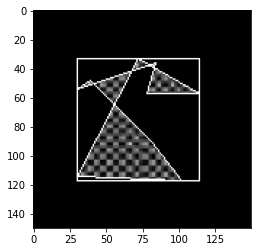

In [13]:
example_single_img, example_bbox = generate_single_dot_distortion(seed=None, draw_bbox=True)

plt.imshow(example_single_img, cmap='gray')

I created a grayscale image that shows the 5 areas in the 21x21 grid of pixels.


![](dot_distortion_areas.png)

In [14]:
def place_small_img_on_large_img(large_img, small_img, coords):
    '''
    Place small_img on large_img at coords
    
    large_img (np.array): image to place small_img on
    small_img (np.array): image to place on large_img
    coords (tuple(int,int)): (x, y) point coordinates of top-left of small image
    '''
    large_img[coords[0]:coords[0]+small_img.shape[0], coords[1]:coords[1]+small_img.shape[1]] = small_img
    return large_img

In [15]:
def visual_search_display(shape_image=None, shape_bbox=None, shape_category=None, total_shapes=7, width=640, height=480, margin=40, draw_bboxes=False):
    '''
    Create a width*height image with shape_image placed randomly on it. One of them will be shape_image if given.
    
    shape_image (np.ndarray): Image of relevant category. If None, all shapes will be random.
    shape_bbox (tuple(int,int,int,int)): Bounding box of shape_image. If None, all shapes will be random.
    shape_category (str): Category of shape_image. If None, all shapes will be random.
    total_shapes (int): Total number of shapes to place on the image
    width (int): Width of the final image
    height (int): Height of the final image
    margin (int): Margin, no shape in magin 
    '''
    zero_img = np.zeros([height, width],np.uint8)
    img = np.copy(zero_img)
    bboxes = []
    if shape_image is not None:
        to_shift_coords = (random.randint(margin,height-margin-shape_image.shape[0]), random.randint(margin,width-margin-shape_image.shape[1]))
        new_img = place_small_img_on_large_img(
            large_img = zero_img, 
            small_img = shape_image, 
            coords = to_shift_coords
            )
        new_bbox = (
            shape_bbox[0] + to_shift_coords[1], #x1
            shape_bbox[1] + to_shift_coords[0], #y1
            shape_bbox[2] + to_shift_coords[1], #x2
            shape_bbox[3] + to_shift_coords[0] #y2
        )
        bboxes.append({
            'category': shape_category,
            'bbox': new_bbox
        })
        img = cv2.bitwise_or(img, new_img)
    for i in range(total_shapes-(1 if shape_image is not None else 0)):
        single_img, single_bbox = generate_single_dot_distortion(seed=None)
        to_shift_coords = (random.randint(margin,height-margin-single_img.shape[0]), random.randint(margin,width-margin-single_img.shape[1]))
        new_img = place_small_img_on_large_img(
            large_img = zero_img, 
            small_img = single_img,
            coords = to_shift_coords
        )
        new_bbox = (
            single_bbox[0] + to_shift_coords[1], #x1
            single_bbox[1] + to_shift_coords[0], #y1
            single_bbox[2] + to_shift_coords[1], #x2
            single_bbox[3] + to_shift_coords[0] #y2
        )
        img = cv2.bitwise_or(img, new_img)
        bboxes.append({
            'category' : 'other',
            'bbox' : new_bbox
        })
    if draw_bboxes:
        for bbox in bboxes:
            cv2.rectangle(img, bbox['bbox'][0:2], bbox['bbox'][2:4], (255,255,255), 1)
            
    return img, bboxes


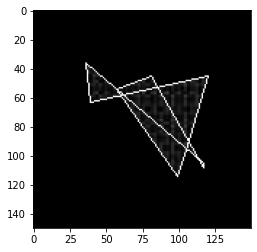

In [16]:
example_shape, bbox = generate_single_dot_distortion(seed=2, distortion_level='5')

plt.imshow(example_shape, cmap='gray')

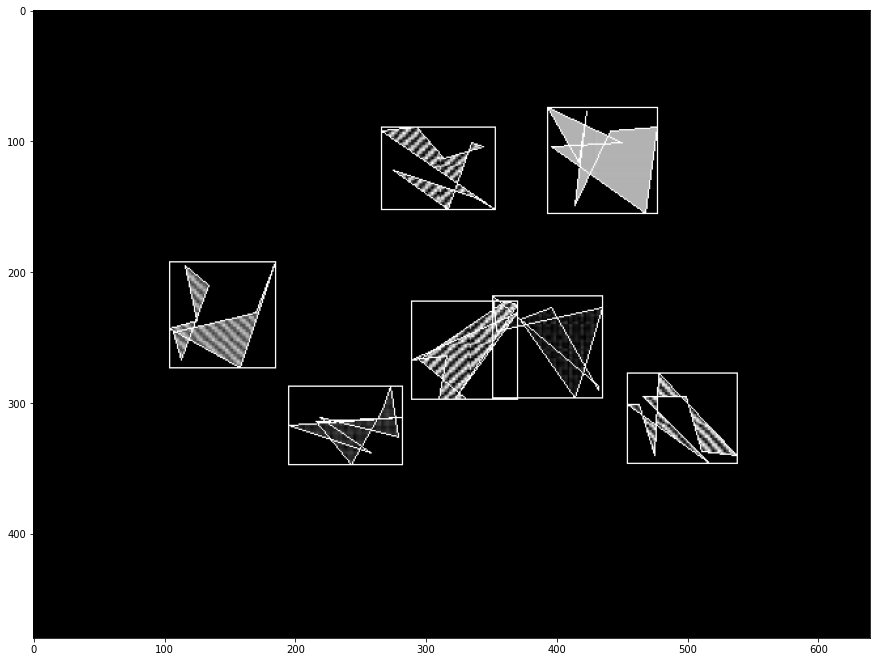

In [17]:
plt.figure(figsize=(15,15))

final_image, final_bboxes = visual_search_display(shape_image=example_shape, shape_bbox=bbox, shape_category='A', total_shapes=7, width=640, height=480, margin=40, draw_bboxes=True)
plt.imshow(final_image, cmap='gray')

In [18]:
final_bboxes

[{'category': 'A', 'bbox': (351, 218, 435, 296)},
 {'category': 'other', 'bbox': (104, 192, 185, 273)},
 {'category': 'other', 'bbox': (195, 287, 282, 347)},
 {'category': 'other', 'bbox': (289, 222, 370, 297)},
 {'category': 'other', 'bbox': (266, 89, 353, 152)},
 {'category': 'other', 'bbox': (454, 277, 538, 346)},
 {'category': 'other', 'bbox': (393, 74, 477, 155)}]

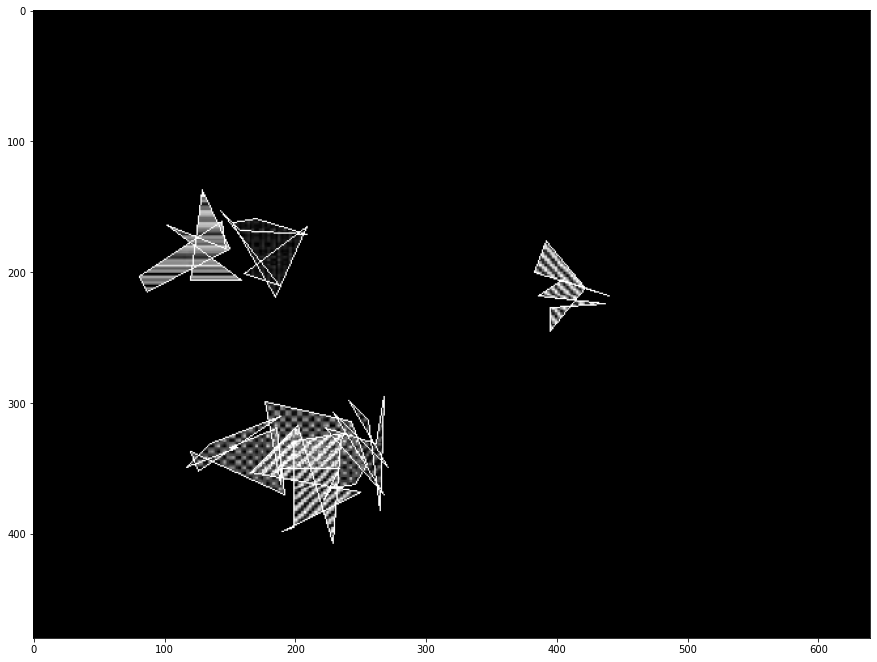

In [19]:
plt.figure(figsize=(15,15))

final_image, final_bboxes = visual_search_display(draw_bboxes=False)

plt.imshow(final_image, cmap='gray')

In [20]:
final_bboxes

[{'category': 'other', 'bbox': (383, 176, 440, 245)},
 {'category': 'other', 'bbox': (117, 310, 192, 370)},
 {'category': 'other', 'bbox': (81, 137, 159, 215)},
 {'category': 'other', 'bbox': (223, 295, 271, 382)},
 {'category': 'other', 'bbox': (166, 317, 250, 407)},
 {'category': 'other', 'bbox': (177, 299, 255, 374)},
 {'category': 'other', 'bbox': (143, 153, 209, 219)}]